## Importing packages & setting up connection

In [28]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import seaborn as sns
import math
from scipy import stats
import statsmodels.api as sm

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    #"role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "frostbyte_tasty_bytes",
    #"schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 1. Loading of Datasets <a id="part1"></a>

In [30]:
order_header_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.order_header")
customer_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_customer.customer_loyalty")

In [31]:
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|82686170    |239         |6185.0         |NULL           |NULL           |232187      |15:30:00            |22:30:00          |NULL             |2021-04-

In [32]:
customer_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

## 2. Data Preparation <a id="part2"></a>

### 2.1 Create dataframe <a id="part2-1"></a>
Our group will be focusing on the customers based in the US. Hence, we will need to filter the customer data to US. We are also doing basic data preparation to prepare our datasets so far for subsequent steps. 

In [33]:
# Filtering of customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")
us_customer_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |Donald        |Faulkner     |San Mateo  |United States  |94010          |English               |Male         |NULL               |Single              |0                 |201

In [34]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only

customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
order_header_df = order_header_df.join(customer_US, order_header_df.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

### 2.2 Calculation of Recency <a id="part2-2"></a>

In [35]:
# Finding the last order time stamp for each customer
customer_last_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_timestamp.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|88866          |2022-10-19 19:27:34  |
|25892          |2022-10-28 17:02:25  |
|146098         |2022-10-30 20:53:59  |
|33079          |2022-10-09 21:50:03  |
|53560          |2022-10-17 15:52:46  |
|197014         |2022-09-24 11:45:02  |
|140606         |2022-10-25 08:04:21  |
|57727          |2022-10-16 13:52:32  |
|74923          |2022-10-30 12:54:08  |
|115473         |2022-10-27 17:38:28  |
---------------------------------------



In [36]:
# Finding the first and latest transaction timestamps

# First transaction timestamp
order_header_df.agg(F.min("ORDER_TS")).show()

# Lastest transaction timestamp
order_header_df.agg(F.max("ORDER_TS")).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [37]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency = customer_last_order_timestamp.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), "2022-11-01", "0"))

# Calculate recency days
customer_recency = customer_recency.with_column("RECENCY_DAYS", F.datediff('day', customer_recency["LAST_ORDER_TS"], customer_recency["CURRENT DATE"]))
customer_recency.show()

-------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"  |"RECENCY_DAYS"  |
-------------------------------------------------------------------------
|23949          |2022-10-16 17:28:07  |2022-11-01      |16              |
|27971          |2022-10-26 08:52:56  |2022-11-01      |6               |
|193091         |2022-10-20 18:49:41  |2022-11-01      |12              |
|187890         |2022-10-08 09:50:11  |2022-11-01      |24              |
|44825          |2022-10-06 12:12:41  |2022-11-01      |26              |
|88758          |2022-10-25 19:47:45  |2022-11-01      |7               |
|145672         |2022-10-25 09:10:41  |2022-11-01      |7               |
|158649         |2022-10-30 09:08:40  |2022-11-01      |2               |
|92481          |2022-10-06 21:07:37  |2022-11-01      |26              |
|97283          |2022-11-01 09:52:42  |2022-11-01      |0               |
--------------------------------------

In [38]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_final = temp_customer_recency.join(customer_df, 
                                customer_df.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

In [39]:
customer_final.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |3               |118                    |Donald   

### 2.3 Calculation of Frequency <a id="part2-3"></a>

In [40]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_header_df.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|142566         |2020-02-08 16:28:22  |
|127035         |2020-01-20 22:14:08  |
|170432         |2020-01-12 10:48:59  |
|48066          |2020-01-03 19:06:33  |
|140862         |2020-04-02 09:28:21  |
---------------------------------------



In [41]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_header_df.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|155220         |61             |
|123639         |79             |
|175564         |58             |
|87521          |57             |
|137288         |66             |
---------------------------------



In [42]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-08-01", "0"))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

In [43]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_final = temp_customer_freq.join(customer_final, 
                                customer_final.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

### 2.4 Calculation of Monetary Value <a id="part2-4"></a>

In [44]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_header_df.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), "2022-08-01", "0"))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [45]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_freq = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_final = temp_customer_freq.join(customer_final, customer_final.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

### 2.5 Final DataFrame with RFM Calculations <a id="part2-5"></a>

In [46]:
customer_final = customer_final.select(
    ["CUSTOMER_ID", "BIRTHDAY_DATE", 
     "RECENCY_DAYS", "CUSTOMER_FREQUENCY", "MONETARY_VALUE"])
customer_final.show()

----------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |
----------------------------------------------------------------------------------------------
|118            |1988-06-13       |3               |13.904763             |493.3583897171    |
|189            |1984-03-05       |2               |15.349034             |589.7098848393    |
|204            |1979-06-25       |8               |14.972283             |511.0809057665    |
|42             |1966-06-28       |6               |12.331080             |560.2934303707    |
|59             |1961-06-05       |6               |12.125214             |412.1018343895    |
|65             |1958-09-01       |19              |13.659705             |447.0376706073    |
|106            |1967-05-10       |3               |17.131226             |750.8896000873    |
|219            |1965-12-19       |6              

### 2.6 Calculating Customer's Age <a id="part2-6"></a>

In [47]:
# Calculating of the age of each customer based on the last order transaction date recorded based on all customers as current date 
last_date = order_header_df.agg(F.max("ORDER_TS")).collect()[0][0]
customer_final = customer_final.withColumn("LAST_DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), last_date, last_date))
customer_final = customer_final.withColumn("AGE", F.datediff("year", F.col("BIRTHDAY_DATE"), F.col("LAST_DATE")))

# Drop "LAST_DATE"
customer_final = customer_final.drop("LAST_DATE", "BIRTHDAY_DATE")

customer_final.show()

------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"RECENCY_DAYS"  |"CUSTOMER_FREQUENCY"  |"MONETARY_VALUE"  |"AGE"  |
------------------------------------------------------------------------------------
|118            |3               |13.904763             |493.3583897171    |34     |
|189            |2               |15.349034             |589.7098848393    |38     |
|204            |8               |14.972283             |511.0809057665    |43     |
|42             |6               |12.331080             |560.2934303707    |56     |
|59             |6               |12.125214             |412.1018343895    |61     |
|65             |19              |13.659705             |447.0376706073    |64     |
|106            |3               |17.131226             |750.8896000873    |55     |
|219            |6               |15.498938             |520.1831044528    |57     |
|222            |18              |12.892465             |547.9297

### 2.7 Converting to Pandas <a id="part2-7"></a>

In [48]:
# Converting of dataframe to pandas for clustering of model 
customer_final = customer_final.to_pandas()

# Check Dtype of each columns
customer_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CUSTOMER_ID         46300 non-null  int32 
 1   RECENCY_DAYS        46300 non-null  int32 
 2   CUSTOMER_FREQUENCY  46300 non-null  object
 3   MONETARY_VALUE      46300 non-null  object
 4   AGE                 46300 non-null  int32 
dtypes: int32(3), object(2)
memory usage: 1.2+ MB


In [49]:
# Converting all columns to numeric datatype
customer_final["CUSTOMER_FREQUENCY"] = customer_final["CUSTOMER_FREQUENCY"].astype("float")
customer_final["MONETARY_VALUE"] = customer_final["MONETARY_VALUE"].astype("float")

In [50]:
# Overview of the final customer dataset to be used for clustering
customer_final.head(5)

,CUSTOMER_ID,RECENCY_DAYS,CUSTOMER_FREQUENCY,MONETARY_VALUE,AGE
0,118,3,13.904763,493.358390,34
1,189,2,15.349034,589.709885,38
2,204,8,14.972283,511.080906,43
3,42,6,12.331080,560.293430,56
4,59,6,12.125214,412.101834,61


### 2.8 Scaling <a id="part2-8"></a>

In [51]:
# Scale data
scaler = StandardScaler()
customer_final_scaled = scaler.fit_transform(customer_final)
customer_final_scaled = pd.DataFrame(customer_final_scaled, columns=customer_final.columns)

### 2.9 Creating different dataframes <a id="part2-9"></a>

#### DataFrame 1 - Contains all the features
- Customer_ID
- RECENCY_DAYS
- CUSTOMER_FREQUENCY
- MONETARY_VALUE
- AGE

In [52]:
all_var = customer_final_scaled.values
all_var

array([[-2.08692722, -0.67745453, -1.27935361, -1.35468067, -0.80366928],
       [-2.0855851 , -0.75798854, -0.97317824, -0.88262187, -0.59551401],
       [-2.08530155, -0.27478448, -1.05304682, -1.26785202, -0.33531993],
       ...,
       [ 1.40066806, -0.67745453, -1.04280947, -0.23944775, -1.4801739 ],
       [ 1.59716641, -0.51638651,  0.69475333, -0.10532005, -0.59551401],
       [ 1.62024717,  1.49696375, -1.69425256, -1.81562833,  0.60137878]])

#### DataFrame 2 - Contains 4 features
- Customer_ID
- CUSTOMER_FREQUENCY
- MONETARY_VALUE
- AGE

In [53]:
chosen_4var = all_var[:, [0, 2, 3, 4]]

#### DataFrame 2 - Contains 3 features
- Customer_ID
- MONETARY_VALUE
- AGE

In [54]:
chosen_3var = all_var[:, [0, 3, 4]]

## 3. K-Means Clustering <a id="part3"></a>

### 3.1 DataFrame 1 - Contains all the features <a id="part3.1"></a>
To find out the optimal number of clusters for K-Means Clustering, we used the elbow method. The cluster range we used was from 1 to 10. 

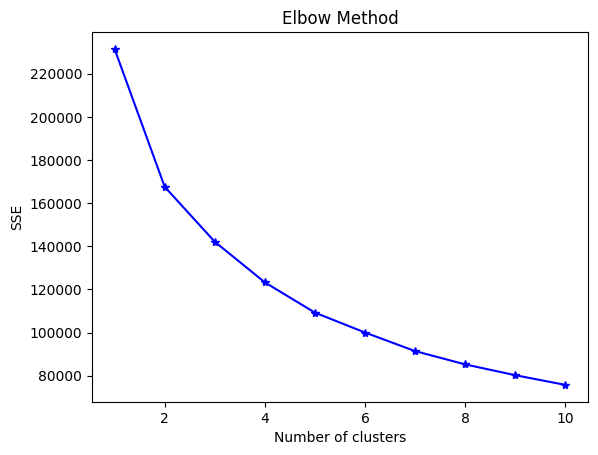

In [55]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init = 20, random_state=1)
    kmeans.fit(all_var)
    sse.append(kmeans.inertia_)

# Plot the SSE (Sum of Squared Errors) values against the number of clusters
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Based on the visualization above, we can see that the optimal number of clusters would be 5. 

#### K-Means Model 1

The first K-Means Model I have built is based on 5 clusters.  

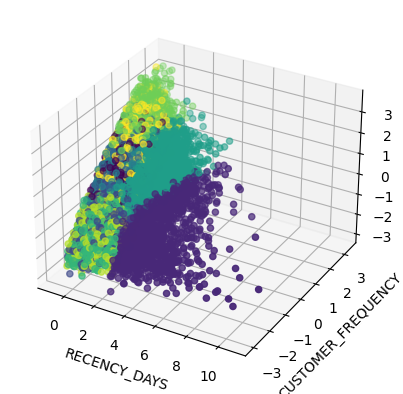

Silhouette score for 5 clusters:  0.20840150079339279


In [56]:
# Perform K-means clustering with 5 clusters
kmeans1_all = KMeans(n_clusters=5, n_init = 20, random_state=1)
predict_kmeans1_all = kmeans1_all.fit_predict(all_var)

# Visualize the clustering results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(all_var[:, 1], all_var[:, 2], 
             all_var[:, 3], c=predict_kmeans1_all)
ax.set_xlabel('RECENCY_DAYS')
ax.set_ylabel('CUSTOMER_FREQUENCY')
ax.set_zlabel('MONETARY_VALUE')
plt.show()

# Compute the silhouette score
ss = silhouette_score(all_var, kmeans1_all.fit_predict(all_var))

# Print the silhouette score
print("Silhouette score for 5 clusters: ", ss)

### 3.2 DataFrame 2 - Contains 4 features <a id="part3.2"></a>

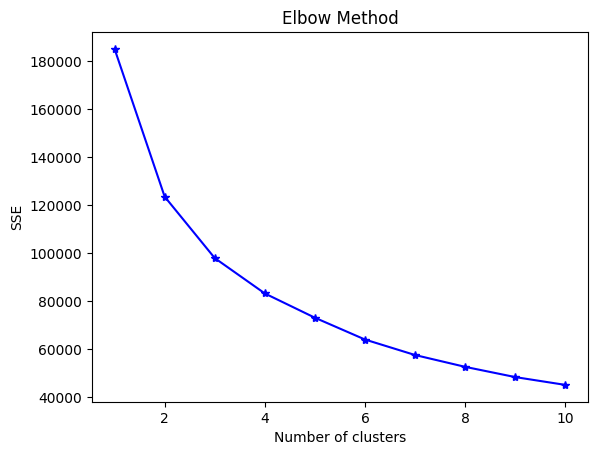

In [57]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init = 20, random_state=1)
    kmeans.fit(chosen_4var)
    sse.append(kmeans.inertia_)

# Plot the SSE (Sum of Squared Errors) values against the number of clusters
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Based on the visualization above, we can see that the optimal number of clusters would be 4. 

#### K-Means Model 2

The next K-Means Model we have built is based on 4 clusters using the dataframe that contains only 4 features.  

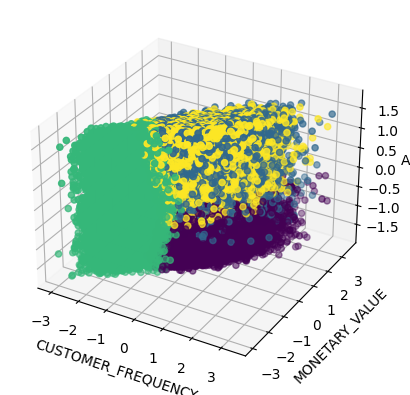

Silhouette score for 4 clusters:  0.2587976158027241


In [59]:
# Perform K-means clustering with 4 clusters
kmeans2_4var = KMeans(n_clusters=4, n_init = 20, random_state=1)
predict_kmeans2_4var = kmeans2_4var.fit_predict(chosen_4var)

# Visualize the clustering results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(chosen_4var[:, 1], chosen_4var[:, 2], 
             chosen_4var[:, 3], c=predict_kmeans2_4var)
ax.set_xlabel('CUSTOMER_FREQUENCY')
ax.set_ylabel('MONETARY_VALUE')
ax.set_zlabel('AGE')
plt.show()

# Compute the silhouette score
ss = silhouette_score(chosen_4var, kmeans2_4var.fit_predict(chosen_4var))

# Print the silhouette score
print("Silhouette score for 4 clusters: ", ss)

### 3.3 DataFrame 3 - Contains 3 features <a id="part3.3"></a>

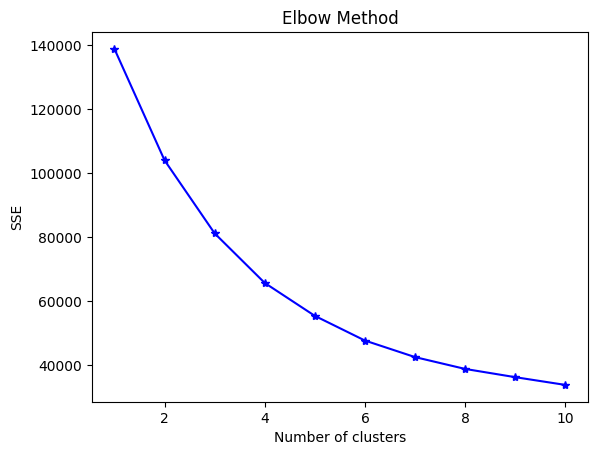

In [60]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init = 20, random_state=1)
    kmeans.fit(chosen_3var)
    sse.append(kmeans.inertia_)

# Plot the SSE (Sum of Squared Errors) values against the number of clusters
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Based on the visualization above, we can see that the optimal number of clusters would be 5. 

#### K-Means Model 3

The next K-Means Model we have built is based on 5 clusters using the dataframe that contains only 3 features.  

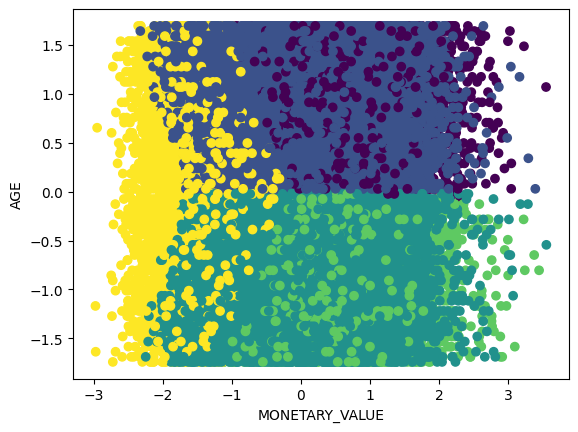

Silhouette score for 5 clusters:  0.26345242024212506


In [61]:
# Perform K-means clustering with 5 clusters
kmeans3_3var = KMeans(n_clusters=5, n_init = 20, random_state=1)
predict_kmeans3_3var = kmeans3_3var.fit_predict(chosen_3var)

# Visualize the clustering results
plt.scatter(chosen_3var[:,1], chosen_3var[:,2], c=predict_kmeans3_3var)
plt.xlabel('MONETARY_VALUE')
plt.ylabel('AGE')
plt.show()

# Compute the silhouette score
ss = silhouette_score(chosen_3var, kmeans3_3var.fit_predict(chosen_3var))

# Print the silhouette score
print("Silhouette score for 5 clusters: ", ss)